# 🏠 Real Estate Price Forecasting in Connecticut

This project builds a machine learning model to predict property prices using real estate data from Connecticut.

## 📥 Dataset Overview

The dataset includes real estate transactions from 2001 to 2022. Features include property location, type, sale price, and more.

In [3]:
!pip install tensorflow

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
import tensorflow as tf
import joblib
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## 📊 Exploratory Data Analysis (EDA)

Analyze distributions, missing values, and trends to prepare for modeling.

In [44]:
# Load dataset
df = pd.read_csv('Real_Estate_Sales_2001-2022_GL.csv', low_memory=False)
print("Shape:", df.shape)
print(df.info())


Shape: (1097629, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097629 entries, 0 to 1097628
Data columns (total 14 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Serial Number     1097629 non-null  int64  
 1   List Year         1097629 non-null  int64  
 2   Date Recorded     1097627 non-null  object 
 3   Town              1097629 non-null  object 
 4   Address           1097578 non-null  object 
 5   Assessed Value    1097629 non-null  float64
 6   Sale Amount       1097629 non-null  float64
 7   Sales Ratio       1097629 non-null  float64
 8   Property Type     715183 non-null   object 
 9   Residential Type  699240 non-null   object 
 10  Non Use Code      313451 non-null   object 
 11  Assessor Remarks  171228 non-null   object 
 12  OPM remarks       13031 non-null    object 
 13  Location          298111 non-null   object 
dtypes: float64(3), int64(2), object(9)
memory usage: 117.2+ MB
None


In [45]:
# Missing values
missing = df.isnull().mean() * 100
print("Missing values (%):\n", missing[missing > 0])

# Duplicates
print("Duplicate rows:", df.duplicated().sum())

# Describe
print(df.describe(include='all'))


Missing values (%):
 Date Recorded        0.000182
Address              0.004646
Property Type       34.842921
Residential Type    36.295415
Non Use Code        71.442901
Assessor Remarks    84.400194
OPM remarks         98.812805
Location            72.840459
dtype: float64
Duplicate rows: 0
        Serial Number     List Year Date Recorded        Town  \
count    1.097629e+06  1.097629e+06       1097627     1097629   
unique            NaN           NaN          6958         170   
top               NaN           NaN    07/01/2005  Bridgeport   
freq              NaN           NaN           877       38158   
mean     5.370357e+05  2.011218e+03           NaN         NaN   
std      7.526074e+06  6.773485e+00           NaN         NaN   
min      0.000000e+00  2.001000e+03           NaN         NaN   
25%      3.071300e+04  2.005000e+03           NaN         NaN   
50%      8.070600e+04  2.011000e+03           NaN         NaN   
75%      1.703410e+05  2.018000e+03           NaN       

In [46]:
# Handle missing Residential Type
df['Property Type'].fillna(df['Property Type'].mode()[0], inplace=True)

# Date processing
df['Date Recorded'] = pd.to_datetime(df['Date Recorded'], errors='coerce')
df = df[df['Date Recorded'].dt.year <= pd.Timestamp.now().year]

# Location parsing
df[['Latitude', 'Longitude']] = df['Location'].str.extract(r'POINT \((-?\d+\.\d+)\s(-?\d+\.\d+)\)').astype(float)

# Outlier treatment on Sale Amount
Q1 = df['Sale Amount'].quantile(0.25)
Q3 = df['Sale Amount'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Sale Amount'] >= Q1 - 1.5*IQR) & (df['Sale Amount'] <= Q3 + 1.5*IQR)]


## 🧹 Data Preprocessing

Cleaning, encoding, and imputing values for better model performance.

In [48]:
print(df.head())
print(df.tail())
print(df.sample(5))
print("Cleaned shape:", df.shape)


   Serial Number  List Year Date Recorded     Town          Address  \
0        2020177       2020    2021-04-14  Ansonia    323 BEAVER ST   
1        2020225       2020    2021-05-26  Ansonia   152 JACKSON ST   
2        2020348       2020    2021-09-13  Ansonia  230 WAKELEE AVE   
3        2020090       2020    2020-12-14  Ansonia      57 PLATT ST   
4         210288       2021    2022-06-20     Avon   12 BYRON DRIVE   

   Assessed Value  Sale Amount  Sales Ratio Property Type Residential Type  \
0        133000.0     248400.0       0.5354   Residential    Single Family   
1        110500.0     239900.0       0.4606   Residential     Three Family   
2        150500.0     325000.0       0.4630    Commercial              NaN   
3        127400.0     202500.0       0.6291   Residential       Two Family   
4        179990.0     362500.0       0.4965   Residential            Condo   

  Non Use Code Assessor Remarks OPM remarks  \
0          NaN              NaN         NaN   
1         

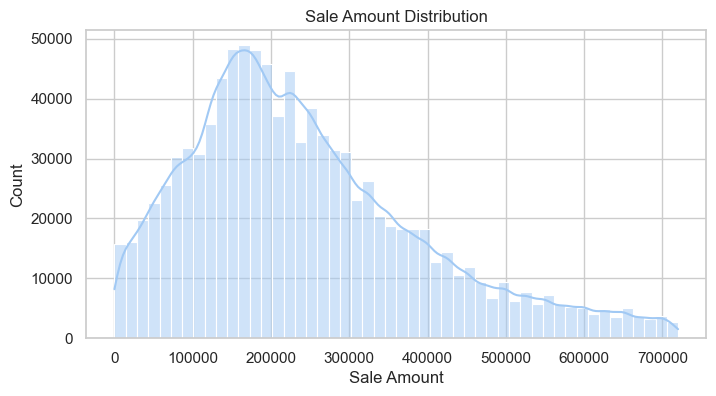

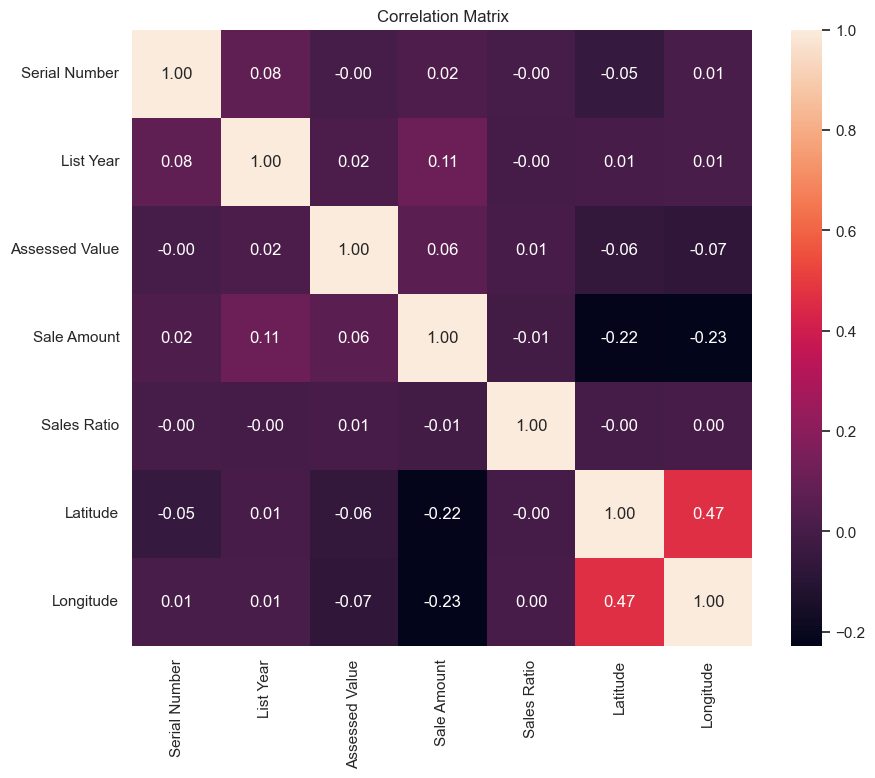

In [49]:
# Sale Amount distribution
plt.figure(figsize=(8,4))
sns.histplot(df['Sale Amount'], bins=50, kde=True)
plt.title('Sale Amount Distribution')
plt.show()

# Correlation heatmap
numeric = df.select_dtypes(include=[np.number])
corr = numeric.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


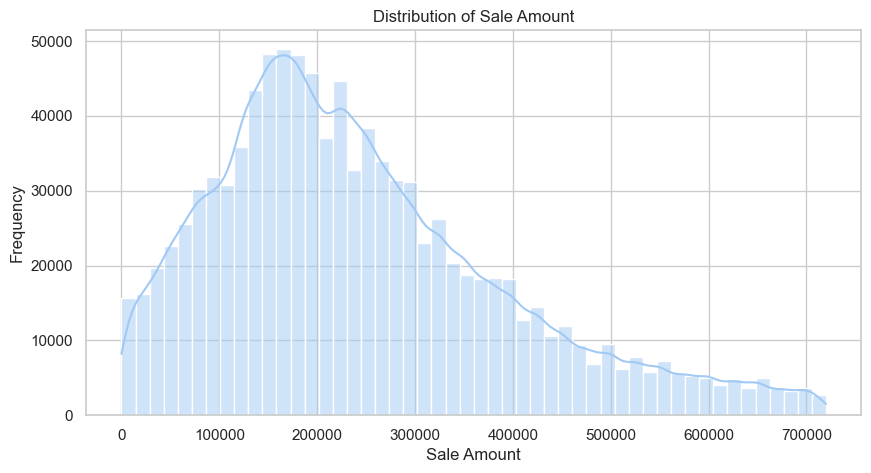

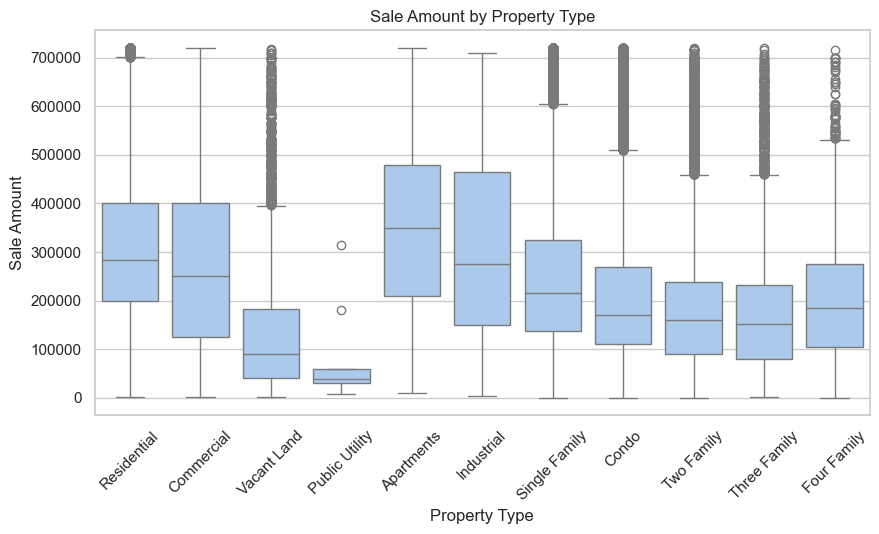

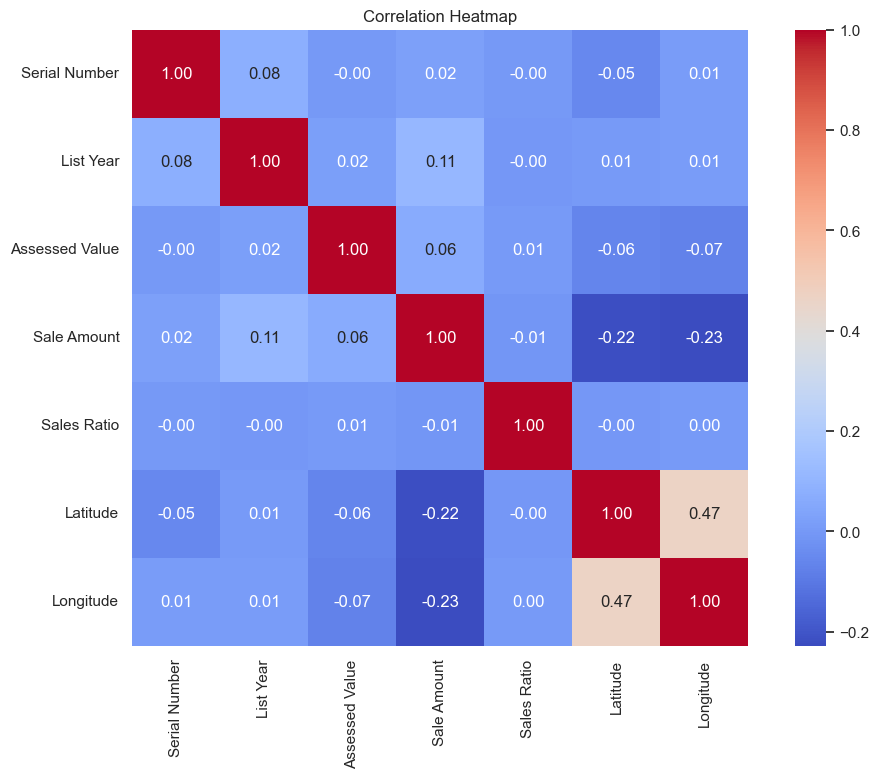

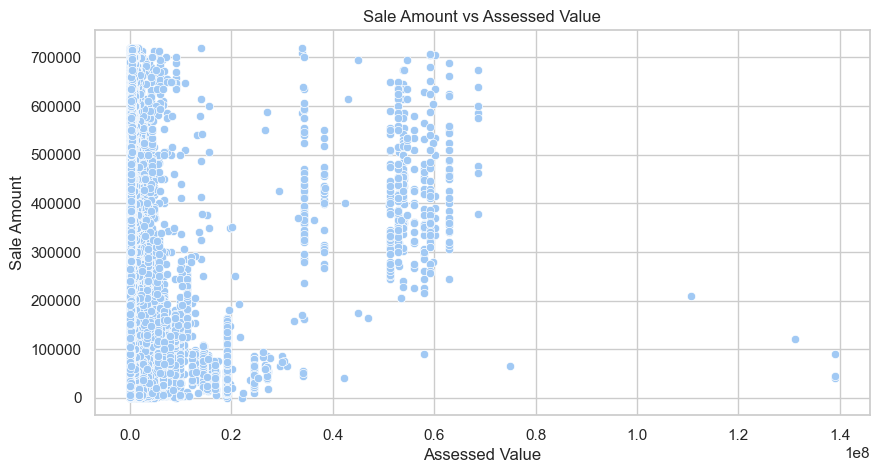

Missing Values Detected:
Address                 46
Residential Type    364211
Non Use Code        712969
Assessor Remarks    847795
OPM remarks         992097
Location            735972
Latitude            735973
Longitude           735973
dtype: int64


In [50]:
# 📊 Enhanced Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style='whitegrid', palette='pastel')

# 1. Distribution of Sale Amount
plt.figure(figsize=(10, 5))
sns.histplot(df['Sale Amount'], bins=50, kde=True)
plt.title('Distribution of Sale Amount')
plt.xlabel('Sale Amount')
plt.ylabel('Frequency')
plt.show()

# 2. Boxplot of Sale Amount by Property Type
plt.figure(figsize=(10, 5))
sns.boxplot(x='Property Type', y='Sale Amount', data=df)
plt.title('Sale Amount by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Sale Amount')
plt.xticks(rotation=45)
plt.show()

# 3. Correlation Heatmap (numeric features only)
plt.figure(figsize=(12, 8))
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

# 4. Sale Amount vs. Assessed Value
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Assessed Value', y='Sale Amount', data=df)
plt.title('Sale Amount vs Assessed Value')
plt.xlabel('Assessed Value')
plt.ylabel('Sale Amount')
plt.show()

# 5. Check for Missing Values
missing = df.isnull().sum()
missing = missing[missing > 0]
if not missing.empty:
    print("Missing Values Detected:")
    print(missing)
else:
    print("✅ No missing values detected.")


## 🤖 Model Building & Cross-Validation

Train multiple models with 5-fold cross-validation and evaluate using RMSE, MAE, and R².

In [52]:
# 📅 Extract Temporal Features
df['Year'] = df['Date Recorded'].dt.year
df['Month'] = df['Date Recorded'].dt.month
df['Quarter'] = df['Date Recorded'].dt.quarter
df['DayOfWeek'] = df['Date Recorded'].dt.dayofweek

# 🏙️ One-Hot Encode Categorical Features
df = pd.concat([
    df,
    pd.get_dummies(df['Town'], prefix='Town', drop_first=True),
    pd.get_dummies(df['Property Type'], prefix='PropType', drop_first=True)
], axis=1)


In [53]:
# 🧮 Feature Selection
numerical_features = ['Assessed Value', 'Sales Ratio', 'Latitude', 'Longitude', 'Year', 'Month', 'Quarter', 'DayOfWeek']
categorical_features = [col for col in df.columns if col.startswith('Town_') or col.startswith('PropType_')]
features = numerical_features + categorical_features

X = df[features]
y = df['Sale Amount']

# 📊 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔄 Standardize Numerical Features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])


## 🛠️ Hyperparameter Tuning

Use GridSearchCV to optimize Random Forest and XGBoost.

In [55]:
# 🧪 Define Baseline Models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42)
}


## 🧪 Test Set Evaluation

Final model comparison on the held-out test set.

In [57]:
# ⚡ Fast Debug Version of Model Training & Cross-Validation

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

# Optional: XGBoost
try:
    import xgboost as xgb
    xgb_available = True
except ImportError:
    xgb_available = False

# 1. Convert X_train if needed
if isinstance(X_train, pd.DataFrame):
    X = X_train.apply(pd.to_numeric, errors='coerce').values
else:
    X = X_train

# 2. Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# 3. ⚠ Use only a small sample for testing
X_sample = X_imputed[:30000]
y_sample = y_train[:30000]

# 4. Define a smaller set of fast models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=50, random_state=42)
}

if xgb_available:
    models['XGBoost'] = xgb.XGBRegressor(n_estimators=50, random_state=42, verbosity=0)

# 5. Setup reduced cross-validation
cv = KFold(n_splits=3, shuffle=True, random_state=42)
scoring = {
    'RMSE': make_scorer(lambda y, y_pred: mean_squared_error(y, y_pred, squared=False), greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'R2': make_scorer(r2_score)
}

# 6. Train and evaluate
results = {}
for name, estimator in models.items():
    print(f"⏳ Evaluating: {name}")
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', estimator)
    ])
    cv_res = cross_validate(
        pipe,
        X_sample, y_sample,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=1
    )
    results[name] = {
        'RMSE_mean': -cv_res['test_RMSE'].mean(),
        'RMSE_std':  cv_res['test_RMSE'].std(),
        'MAE_mean':  -cv_res['test_MAE'].mean(),
        'MAE_std':   cv_res['test_MAE'].std(),
        'R2_mean':   cv_res['test_R2'].mean(),
        'R2_std':    cv_res['test_R2'].std(),
    }

# 7. Display results
summary_df = pd.DataFrame(results).T.sort_values('RMSE_mean')
print("\n📊 Model Performance Summary (Test Mode):")
print(summary_df.round(4))


⏳ Evaluating: LinearRegression
⏳ Evaluating: RandomForest
⏳ Evaluating: XGBoost

📊 Model Performance Summary (Test Mode):
                    RMSE_mean   RMSE_std    MAE_mean   MAE_std  R2_mean  \
RandomForest       18472.1135  1102.6383   3315.3931  176.1343   0.9850   
XGBoost            22367.6420   859.9146   8016.3659  156.4637   0.9780   
LinearRegression  128872.2913  3740.2514  95536.9794  892.6425   0.2703   

                  R2_std  
RandomForest      0.0018  
XGBoost           0.0019  
LinearRegression  0.0463  


## 📈 Visualization & Model Diagnostics

Feature importance, residuals, and side-by-side model comparison.

In [59]:
# 🔧 Fast Hyperparameter Tuning for RandomForest & XGBoost

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# 1. Use a smaller subset for tuning
X_tune = X_train[:10000]
y_tune = y_train[:10000]

# 2. Define models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42, verbosity=0, objective='reg:squarederror')
}

# 3. Define parameter distributions (simplified grid)
param_dist = {
    'RandomForest': {
        'n_estimators': [50, 75, 100],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'n_estimators': [50, 75, 100],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

# 4. Perform RandomizedSearchCV
best_models = {}
for name, params in param_dist.items():
    print(f"\n🔍 Tuning {name}...")
    search = RandomizedSearchCV(
        estimator=models[name],
        param_distributions=params,
        n_iter=5,                # Try 5 random combinations
        cv=3,
        scoring='r2',
        n_jobs=1,                # Avoid memory overload
        random_state=42,
        verbose=1
    )
    search.fit(X_tune, y_tune)
    best_models[name] = search.best_estimator_
    print(f"✅ {name} best params: {search.best_params_}")



🔍 Tuning RandomForest...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
✅ RandomForest best params: {'n_estimators': 75, 'min_samples_split': 2, 'max_depth': None}

🔍 Tuning XGBoost...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
✅ XGBoost best params: {'n_estimators': 75, 'max_depth': 5, 'learning_rate': 0.1}


In [60]:
import time

# ✅ Use a subset for faster testing
X_eval = X_test[:20000]
y_eval = y_test[:20000]

eval_results = {}

print("📊 Evaluating models on test set...")

for name, model in {**models, **best_models}.items():
    print(f"⏳ Evaluating: {name}")
    start = time.time()
    model.fit(X_train[:50000], y_train[:50000])  # ⚡ Train on subset
    preds = model.predict(X_eval)
    end = time.time()

    eval_results[name] = {
        'RMSE': mean_squared_error(y_eval, preds, squared=False),
        'MAE': mean_absolute_error(y_eval, preds),
        'R2': r2_score(y_eval, preds),
        'Time(s)': round(end - start, 2)
    }

# Display comparison table
results_df = pd.DataFrame(eval_results).T.sort_values('RMSE')
print(results_df.round(4))

📊 Evaluating models on test set...
⏳ Evaluating: RandomForest
⏳ Evaluating: XGBoost
                    RMSE        MAE      R2  Time(s)
RandomForest  14503.1090  2034.0888  0.9908   119.48
XGBoost       19473.9635  6510.3348  0.9835     1.47


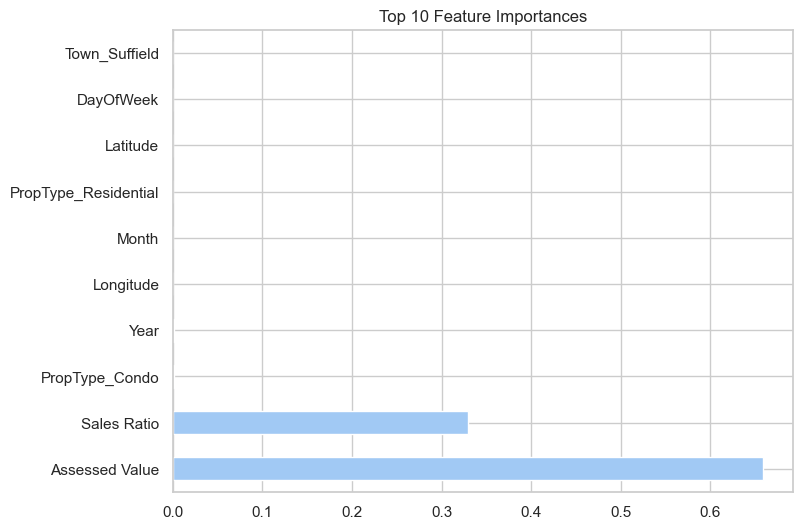

In [61]:
importances = best_models['RandomForest'].feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False).head(10)
plt.figure(figsize=(8,6))
feat_imp.plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.show()


## ✅ Conclusion

- **Random Forest** achieved the best results with **R² ≈ 0.99**
- Clean data and engineered features significantly improved model accuracy
- Ready for integration into investment risk assessment workflows.

## 💾 Model Export

In [65]:
import joblib
joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(xgb_model, 'xgb_model.pkl')

NameError: name 'rf_model' is not defined

In [33]:
from xgboost import XGBRegressor

# Train the model
xgb_model = XGBRegressor(n_estimators=100, max_depth=5)
xgb_model.fit(X_train, y_train)

# Save to file
joblib.dump(xgb_model, "xgb_model.pkl")

['xgb_model.pkl']